In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from copy import deepcopy as dc

from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [2]:
ticker = "GOOGL" # We will check the stock price of google

df = yf.download(ticker, period="5y")

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [3]:
df

Price,Close,High,Low,Open,Volume
Ticker,GOOGL,GOOGL,GOOGL,GOOGL,GOOGL
Date,,,,,
2020-04-06,58.878010,59.254210,55.982354,56.380452,63320000
2020-04-07,58.846657,60.748567,58.582421,60.560961,61620000
2020-04-08,60.062840,60.455960,58.915823,59.868768,40334000
2020-04-09,60.041443,60.808774,59.337309,60.619182,54028000
2020-04-13,60.232533,60.437056,58.835214,59.789153,38702000
...,...,...,...,...,...
2025-03-31,154.639999,155.539993,150.660004,153.110001,54603500
2025-04-01,157.070007,158.100006,153.619995,153.619995,30672900


In [4]:
df = df.reset_index() # Turn date into a column
df = df[['Date', 'Close']] # Only use date and close price to make predictions

df

Price,Date,Close
Ticker,,GOOGL
0,2020-04-06,58.878010
1,2020-04-07,58.846657
2,2020-04-08,60.062840
3,2020-04-09,60.041443
4,2020-04-13,60.232533
...,...,...
1252,2025-03-31,154.639999
1253,2025-04-01,157.070007
1254,2025-04-02,157.039993


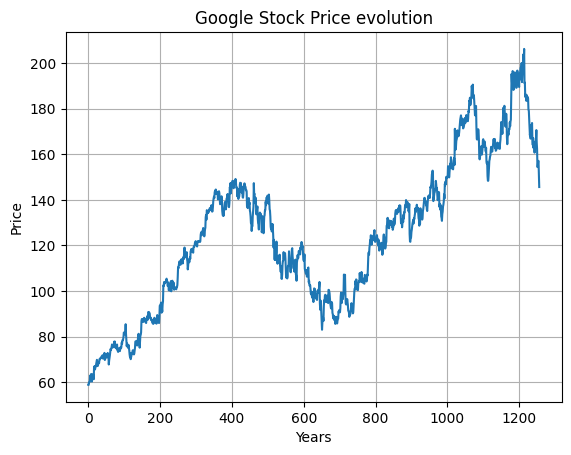

In [5]:
plt.plot(df.index, df['Close'])
plt.title("Google Stock Price evolution")
plt.xlabel("Years")
plt.ylabel("Price")
plt.grid(True)
plt.show()

In [6]:
def prepare_dataframe_for_lstm(df, n_steps):
    df = dc(df)

    df.set_index('Date', inplace=True)

    for i in range(1, n_steps+1):
        df[f'Close(t-{i})'] = df['Close'].shift(i)

    df.dropna(inplace=True)

    return df

lookback = 50
lstm_df = prepare_dataframe_for_lstm(df, lookback)
lstm_df

Price,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7),Close(t-8),Close(t-9),...,Close(t-41),Close(t-42),Close(t-43),Close(t-44),Close(t-45),Close(t-46),Close(t-47),Close(t-48),Close(t-49),Close(t-50)
Ticker,GOOGL,,,,,,,,,,...,,,,,,,,,,
Date,,,,,,,,,,,,,,,,,,,,,
2020-06-17,72.281425,71.979370,70.698990,70.309853,69.761475,72.886528,72.258530,72.057503,71.658401,70.378517,...,62.757458,63.645714,62.572346,62.565880,62.960495,60.232533,60.041443,60.062840,58.846657,58.878010
2020-06-18,71.364807,72.281425,71.979370,70.698990,70.309853,69.761475,72.886528,72.258530,72.057503,71.658401,...,60.319614,62.757458,63.645714,62.572346,62.565880,62.960495,60.232533,60.041443,60.062840,58.846657
2020-06-19,70.893059,71.364807,72.281425,71.979370,70.698990,70.309853,69.761475,72.886528,72.258530,72.057503,...,62.621113,60.319614,62.757458,63.645714,62.572346,62.565880,62.960495,60.232533,60.041443,60.062840
2020-06-22,72.187874,70.893059,71.364807,72.281425,71.979370,70.698990,70.309853,69.761475,72.886528,72.258530,...,63.256073,62.621113,60.319614,62.757458,63.645714,62.572346,62.565880,62.960495,60.232533,60.041443
2020-06-23,72.850700,72.187874,70.893059,71.364807,72.281425,71.979370,70.698990,70.309853,69.761475,72.886528,...,63.526283,63.256073,62.621113,60.319614,62.757458,63.645714,62.572346,62.565880,62.960495,60.232533
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-31,154.639999,154.330002,162.240005,165.059998,170.559998,167.679993,163.990005,162.800003,163.889999,160.669998,...,200.638916,195.185211,195.075333,191.589340,199.979691,197.752243,198.141800,197.822174,195.774521,192.688080
2025-04-01,157.070007,154.639999,154.330002,162.240005,165.059998,170.559998,167.679993,163.990005,162.800003,163.889999,...,203.785309,200.638916,195.185211,195.075333,191.589340,199.979691,197.752243,198.141800,197.822174,195.774521


In [7]:
lstm_df_np = lstm_df.to_numpy()

In [8]:
scaler = MinMaxScaler(feature_range=(-1, 1))
lstm_df_np = scaler.fit_transform(lstm_df_np)

lstm_df_np

array([[-0.93525239, -0.93961925, -0.95812991, ..., -0.9996942 ,
        -1.        , -0.99954983],
       [-0.94850409, -0.93525239, -0.93961925, ..., -1.        ,
        -0.98276544, -1.        ],
       [-0.95532423, -0.94850409, -0.93525239, ..., -0.99726894,
        -0.98306865, -0.98253805],
       ...,
       [ 0.29011583,  0.29054975,  0.25541873, ...,  0.96816528,
         0.9739552 ,  0.99541081],
       [ 0.19874669,  0.29011583,  0.29054975, ...,  1.        ,
         0.96843478,  1.        ],
       [ 0.1247261 ,  0.19874669,  0.29011583, ...,  0.88008496,
         1.        ,  0.99440674]])

In [9]:
X = lstm_df_np[:, 1:]
y = lstm_df_np[:, 0]
X = dc(np.flip(X, axis=1))
split_index = int(len(X) * 0.95)

X_train = X[:split_index]
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

X_train = X_train.reshape((-1, lookback, 1))
X_test = X_test.reshape((-1, lookback, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

In [10]:
# Transfer data to torch tensors

X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

In [11]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [12]:
batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [13]:
device = 'cpu'

for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([16, 50, 1]) torch.Size([16, 1])


In [14]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers,
                            batch_first=True)

        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

model = LSTM(1, 4, 1)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [15]:
def train_one_epoch():
    model.train(True)
    if (epoch + 1) % 10 == 0:
        print(f'Epoch: {epoch + 1}')
    running_loss = 0.0

    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 + 1 == 0:  # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.6f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0


In [16]:
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0

    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)
    if (epoch + 1) % 10 == 0:
        print('Val Loss: {0:.6f}'.format(avg_loss_across_batches))
    return avg_loss_across_batches

In [17]:
loss_tracking = []
lr = 0.001
num_epochs = 10
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

for epoch in range(num_epochs):
    train_one_epoch()
    loss = validate_one_epoch()
    loss_tracking.append(loss)


Epoch: 10
Val Loss: 0.011842


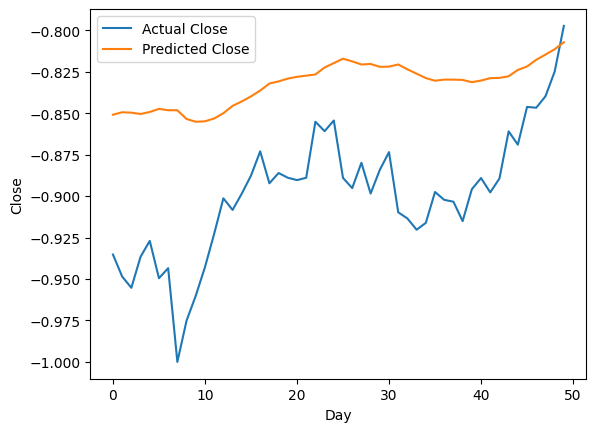

In [18]:

with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()

plt.plot(y_train[:50], label='Actual Close')
plt.plot(predicted[:50], label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [19]:
num_epochs = 100
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

for epoch in range(num_epochs):
    train_one_epoch()
    loss = validate_one_epoch()
    loss_tracking.append(loss)

Epoch: 10
Val Loss: 0.006862
Epoch: 20
Val Loss: 0.005736
Epoch: 30
Val Loss: 0.004361
Epoch: 40
Val Loss: 0.004112
Epoch: 50
Val Loss: 0.003784
Epoch: 60
Val Loss: 0.004016
Epoch: 70
Val Loss: 0.003692
Epoch: 80
Val Loss: 0.003400
Epoch: 90
Val Loss: 0.003757
Epoch: 100
Val Loss: 0.003138


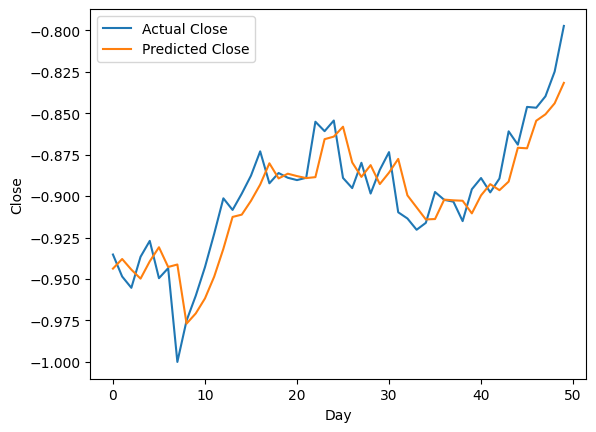

In [20]:
with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()

plt.plot(y_train[:50], label='Actual Close')
plt.plot(predicted[:50], label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

Epoch: 10
Val Loss: 0.003229
Epoch: 20
Val Loss: 0.003184
Epoch: 30
Val Loss: 0.003449
Epoch: 40
Val Loss: 0.003544
Epoch: 50
Val Loss: 0.003100
Epoch: 60
Val Loss: 0.003260
Epoch: 70
Val Loss: 0.003068
Epoch: 80
Val Loss: 0.003222
Epoch: 90
Val Loss: 0.002983
Epoch: 100
Val Loss: 0.003024
Epoch: 110
Val Loss: 0.003080
Epoch: 120
Val Loss: 0.003133
Epoch: 130
Val Loss: 0.003004
Epoch: 140
Val Loss: 0.003015
Epoch: 150
Val Loss: 0.003025
Epoch: 160
Val Loss: 0.003105
Epoch: 170
Val Loss: 0.003204
Epoch: 180
Val Loss: 0.003267
Epoch: 190
Val Loss: 0.003171
Epoch: 200
Val Loss: 0.003368
Epoch: 210
Val Loss: 0.003049
Epoch: 220
Val Loss: 0.003027
Epoch: 230
Val Loss: 0.003180
Epoch: 240
Val Loss: 0.003463
Epoch: 250
Val Loss: 0.003350
Epoch: 260
Val Loss: 0.003090
Epoch: 270
Val Loss: 0.003100
Epoch: 280
Val Loss: 0.003293
Epoch: 290
Val Loss: 0.003562
Epoch: 300
Val Loss: 0.003354


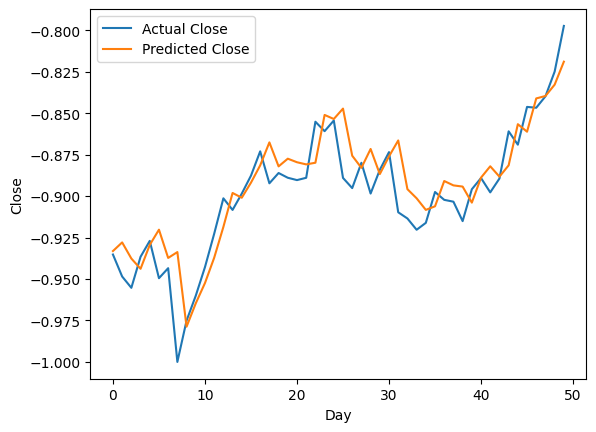

In [21]:
num_epochs = 300

for epoch in range(num_epochs):
    train_one_epoch()
    loss = validate_one_epoch()
    loss_tracking.append(loss)

with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()

plt.plot(y_train[:50], label='Actual Close')
plt.plot(predicted[:50], label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

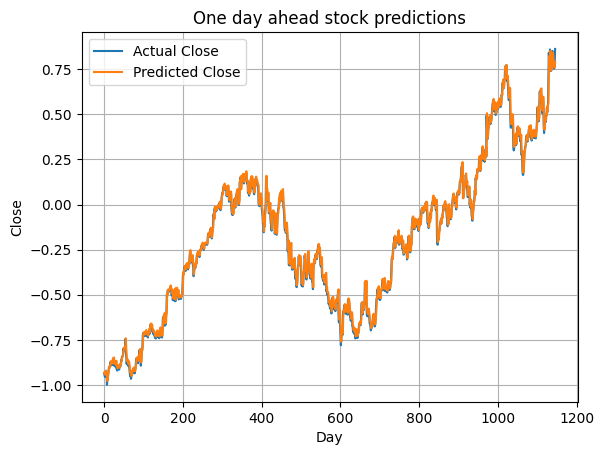

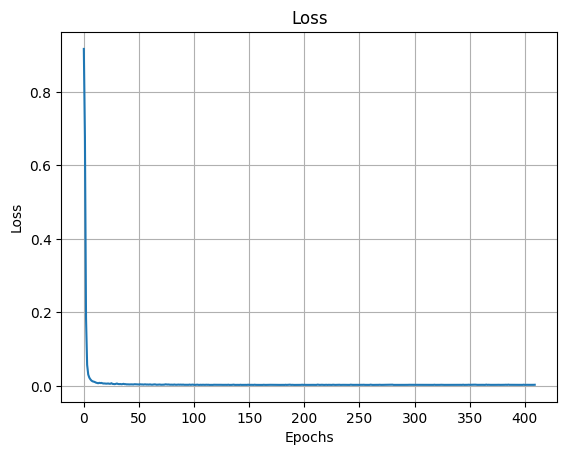

In [22]:
plt.plot(y_train, label='Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.title("One day ahead stock predictions")
plt.grid(True)
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

plt.plot(loss_tracking)
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(True)
plt.show()